# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** We are predicting if a student needs early intervention Yes or No, so this problem is a typical Classification becuase we are looking for a boolean outcome, like yes/no or 0/1, if this was a Regression kind of problem the outcome would be continous.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


## Let's explore the data using describe

In [2]:
student_data.describe

<bound method DataFrame.describe of     school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
5       GP   M   16       U     LE3       T     4     3  services     other   
6       GP   M   16       U     LE3       T     2     2     other     other   
7       GP   F   17       U     GT3       A     4     4     other   teacher   
8       GP   M   15       U     LE3       A     3     2  services     other   
9       GP   M   15       U     GT3       T     3     4     other     other   
10      GP   F   15       U     GT3       T     4     4   teacher    health   
11      GP   F  

In [3]:
# Calculate number of students
n_students = len(student_data)

# Calculate number of features
# We min 1 (-1) bec. the ID kolomn is not needed, so we exclude it
n_features = len(student_data.columns) - 1

# Calculate passing students
n_passed = len(student_data[student_data['passed'] == 'yes'])

# Calculate failing students
n_failed = n_students - n_passed

# Calculate graduation rate
grad_rate = float(n_passed) / float(n_students) * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


### Let's plot the 'absences' values to the 'passed' values to look for a relation.

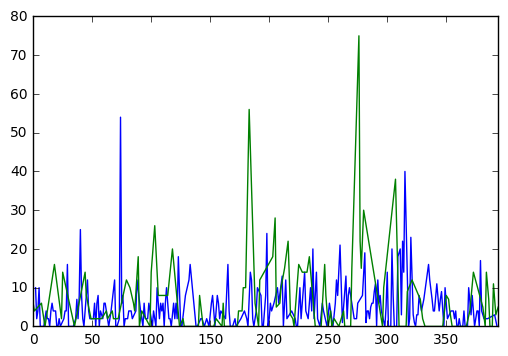

In [4]:
%matplotlib inline
student_data[student_data['passed'] == 'yes']['absences'].plot()
student_data[student_data['passed'] == 'no']['absences'].plot()

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [5]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [6]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [7]:
# Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, random_state=49)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


C:\Users\marti\Anaconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **
## Decision Trees = 
### Describe one real-world application, with resource:
One of the most basic fundamental applications of decision tree analysis is for the purpose of option pricing. The binomial option pricing model uses discrete probabilities to determine the value of an option at expiration. The most basic binomial models assume that the value of the underlying asset will either move up or down, based on calculated probabilities, at the maturity date of the European option. Based on these expected payoff values, the price of the option can easily be determined.
Resource: Using Decision Trees In Finance | Investopedia http://www.investopedia.com/articles/financial-theory/11/decisions-trees-finance.asp#ixzz4UcY8pvo7 
### What are the strengths of the model; when does it perform well?
The strenghts of discission trees are at first that it can handle multiple data sources [features] and it's also a great for solving classification problems, like yes/no or 0/1 (binary)
### What are the weaknesses of the model; when does it perform poorly?
The weaknesses of decision trees are at first that this model could easily overfit. This can be negated by validation methods and pruning, but this is a grey area, and secondly they can have problems out-of-sample prediction. Some of these are related to the problem of multicollinearity: when two variables both explain the same thing, a decision tree will greedily choose the best one, whereas many other methods will use them both. Ensemble methods such as random forests can negate this to a certain extent, but you lose the ease of understanding.
### What makes this model a good candidate for the problem, given what you know about the data?
I think this model will fit great tot the data because it can handle all the availadble features very good and this will lead to a high accurate outcome, so this method will be me personal first choise.


## SVM = Support Vector Machine, 
Support vector machine models are able to find linear connections with maximal margins between datapoints of two classes and are able to separate it. 
### Describe one real-world application, with resource:
Companies are using support vector machines to forecast the production values of the machinery industry in Taiwan, this by solving non-linear regression and time series problems. SVMs are employed to examine the feasibility in forecasting seasonal time series data of production values of Taiwan’s machinery industry. In addition, two other forecasting approaches, namely the seasonal time series autoregressive integrated moving average (SARIMA) model and general regression neural networks (GRNN), are used to compare the performance of forecasting. Resource: http://link.springer.com/article/10.1007/s00170-004-2139-y
### What are the strengths of the model; when does it perform well?
Experimental results show that support vector machines outperform SARIMA and the general regression neural networks in terms of forecasting accuracy to forecast the production values of the machinery industry in Taiwan.
### What are the weaknesses of the model; when does it perform poorly?
The disadvantages are that the theory only really covers the determination of the parameters for a given value of the regularisation and kernel parameters and choice of kernel. In a way the SVM moves the problem of over-fitting from optimising the parameters to model selection. Sadly kernel models can be quite sensitive to over-fitting the model selection criterion, see
Resource: G. C. Cawley and N. L. C. Talbot, Over-fitting in model selection and subsequent selection bias in performance evaluation, Journal of Machine Learning Research, 2010. Research, vol. 11, pp. 2079-2107, July 2010.
### What makes this model a good candidate for the problem, given what you know about the data?
This would be the model of second choise for my model, this beceause the regression could be predicted quite well, but on the other side we have to be very carefull for the risk of overfitting. 


# KNeighbors = 
### Describe one real-world application, with resource:
K-nearest neighbor techniques for pattern recognition are often used for theft prevention in the modern retail business, this by using modern systems that are able to use k-nearest neighbor for visual pattern recognition to scan and detect hidden packages in the bottom bin of a shopping cart at check-out. 
Resource: http://www.dummies.com/programming/big-data/data-science/solving-real-world-problems-with-nearest-neighbor-algorithms/
### What are the strengths of the model; when does it perform well?
When the data is not linear regressed, but curved for example the KNeighbours function will fit better than a Logistic regression model, this beceause the line is formed by the data around all the datapoints, it perfoms well if all the data is availadble and easy accesable. 
### What are the weaknesses of the model; when does it perform poorly?
The weakness of this model is that is haves high computation coststs, it's time consuming when we have a lot of datapoints.
### What makes this model a good candidate for the problem, given what you know about the data?
I don't think that this model is a great fit to the data, this because we have a lot of datapoints from different fields and I doubt if this model is the best fit to find the patterns / regressions in it for the best accurate predictions of all three models.

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [8]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
# Import the three supervised learning models from sklearn
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Initialize the three models
clf_A = tree.DecisionTreeClassifier(random_state=1)
clf_B = SVC(random_state=1)
clf_C = KNeighborsClassifier()

# Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# Execute the train_predict function for each classifier & each training set size

### DecisionTreeClassifier

In [10]:
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0040 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7536.
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0040 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7746.
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0050 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.6818.


### SVM

In [11]:
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)

Training a SVC using a training set size of 100. . .
Trained model in 0.0050 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8671.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.8199.
Training a SVC using a training set size of 200. . .
Trained model in 0.0060 seconds
Made predictions in 0.0040 seconds.
F1 score for training set: 0.8644.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.8101.
Training a SVC using a training set size of 300. . .
Trained model in 0.0120 seconds
Made predictions in 0.0060 seconds.
F1 score for training set: 0.8486.
Made predictions in 0.0030 seconds.
F1 score for test set: 0.8129.


### KNeighborsClassifier

In [12]:
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0040 seconds
Made predictions in 0.0040 seconds.
F1 score for training set: 0.8727.
Made predictions in 0.0030 seconds.
F1 score for test set: 0.7975.
Training a KNeighborsClassifier using a training set size of 200. . .
Trained model in 0.0020 seconds
Made predictions in 0.0070 seconds.
F1 score for training set: 0.8407.
Made predictions in 0.0060 seconds.
F1 score for test set: 0.7724.
Training a KNeighborsClassifier using a training set size of 300. . .
Trained model in 0.0030 seconds
Made predictions in 0.0100 seconds.
F1 score for training set: 0.8657.
Made predictions in 0.0070 seconds.
F1 score for test set: 0.7714.


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** DecisionTreeClassifier **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0080           |        0.0010          |      1.000       |    0.7391       |
| 200               |        0.0040           |        0.0010          |      1.000       |    0.7385       |
| 300               |        0.0050           |        0.0010          |      1.000       |    0.6719       |

** SVM **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0060           |        0.0020          |       0.8671     |     0.8199      |
| 200               |        0.0060           |        0.0040          |       0.8644     |     0.8101      |
| 300               |        0.0120           |        0.0070          |       0.8486     |     0.8129      |

** KNeighborsClassifier **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |          0.0040         |        0.0080          |        0.8722    |    0.7975       |
| 200               |          0.0040         |        0.0070          |        0.8407    |    0.7724       |
| 300               |          0.0020         |        0.0080          |        0.8587    |    0.7714       |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** *Based on the experiments I performed earlier, I would explain to the board of supervisors that the SVM model is the best model to use predicting which student's need the intervention, this because this model showes the highest accuracy on our test data, 81,99% is we feed the model 100 records, this is the best accuracy compared to our other two models, that are showing accuracy's of 73,91% (DecisionTreeClassifier) and 79,75 (SVM / Kernel) when also runned on the 100 sized Test data set.

The SVM model is generally the most appropriate based on the available data, but not apiclabl when limited resources are availadble, this because the model need the actual data to make a run, and when running the model uses a lot of computational power, to run for the prediction. The two disadvantages are not a reason to decide for another model at all, this because our training set only needs 100 records to train itself for the prediction on our also small Test data set.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

In [3]:
cd 

C:\Users\marti\Google Drive\Udacity\Machine Learning\machine-learning-master\machine-learning-master\projects\student_intervention


**Answer: ** The SVM (Support Vector Machine) method (support vector machine) looks at the data find the ideal line that separates the data into two classes, in this case our two classes would be: "Intervention needed" and "No intervention needed". 

While finding the "ideal" line to separate the data into the two classes it uses a parameter called the "margin" to find the closest point from the line to the nearest point of a datapoint in both two classes, look at the picture below for a visual representation of this process.

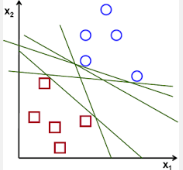

In [1]:
from IPython.display import Image
Image(filename='C:\Users\marti\Google Drive\Udacity\Machine Learning\Submissions\pictures/image_1.png')

The "kernel trick" is often used to diffrentiate the data, think of finding the closest points to the original by using a circle function to find the "Support Vectors" that are closest to the dataser for example, look at the picture below for a visual representation of the kernel trick. 

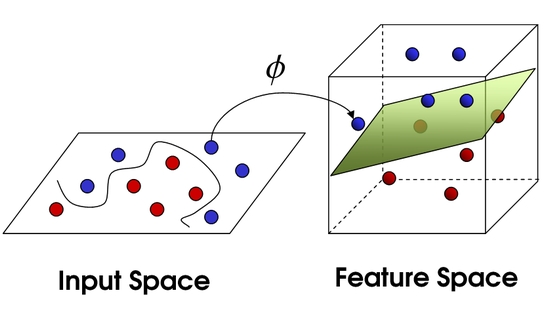

In [2]:
from IPython.display import Image
Image(filename='C:\Users\marti\Google Drive\Udacity\Machine Learning\Submissions\pictures/image_2.png')

Intuitively, a kernel is just a transformation of your input data that allows you (or an algorithm like SVMs) to treat/process it more easily. Imagine that we have the toy problem of separating the red circles from the blue crosses on a plane as shown below. 

Our separating surface would be the ellipse drawn on the left figure. However, transforming our data into a 3 dimensional space through the mapping shown in the figure would make the problem much easier since, now, our points are separated by a simple plane. This embedding on a higher dimension is called the kernel trick. 

In conclusion, and very informally, a kernel consists on embedding general points into an inner product space like we see in the picture below.

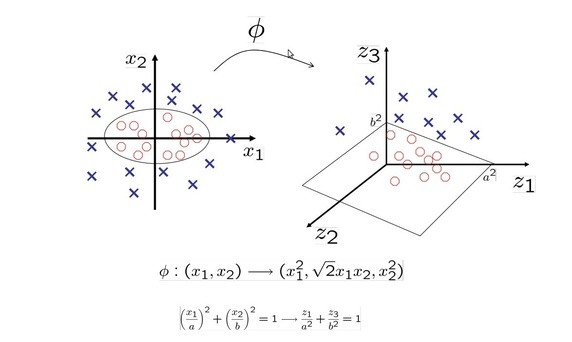

In [3]:
from IPython.display import Image
Image(filename='C:\Users\marti\Google Drive\Udacity\Machine Learning\Submissions\pictures/image_3.png')

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [13]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# TODO Create the parameters list you wish to tune
parameters = {'C': [1, 10, 100, 200, 300, 400, 500, 600, 700],
   'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
   'kernel': ['rbf'], 'tol':[1e-3, 1e-4, 1e-5, 1e-6]}

svc = svm.SVC()

# Initialize the classifier
clf = clf_B

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label="yes")

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring = f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0050 seconds.
Tuned model has a training F1 score of 0.8266.
Made predictions in 0.0020 seconds.
Tuned model has a testing F1 score of 0.8289.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** The final mofels f1 score is 82,89%, this is almost a procent higher than our untunded model which showed us 81,99%.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.